# Part 1 - Historical Structure Identifiaction #

# Constants

In [30]:
import pytz
height = 224
width = 224
batch_size = 64
total_train_images = 0
total_test_images = 0

cnn = 'CNN'
mobilenet = 'MobileNetV2'
vgg16 = 'VGG16'
efficientnet = 'EfficientNetV2B0'

train_accuracy = {}
test_accuracy = {}
train_loss = {}
test_loss = {}
model_map = {}
history_map = {}

patience = 10
delta = 0.05

timezone = pytz.timezone('Asia/Kolkata')


## Common Functions

In [47]:
from datetime import datetime
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import pandas as pd
import pprint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from  tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')


def now() -> None:
  '''
  Returns the current date time in the format specified
  :return: current date time
  '''
  return datetime.now(timezone).strftime("%Y-%m-%d:%H:%M:%S")

def update_model_map(model_name,model)-> None:
  '''
  Updates a dictionary with model name and model object
  :param model_name:
  :param model:
  :return: None
  '''
  model_map[model_name] = model


def print_with_ts(message)->None:
  '''
  prints the message with a timestamp
  :param message:
  :return: None
  '''
  print(now())
  print(message)


def print_scores(model, val_ds, train_ds,name)-> None:
    '''
    Prints the accuracy and loss for the given model
    :param model:
    :param val_ds:
    :param train_ds:
    :param name:
    :return: None
    '''
    print(f'Displaying accuracy and loss for {name}')

    score_test = model.evaluate(val_ds, verbose=0)
    score_train = model.evaluate(train_ds, verbose=0)
    test_loss[name] = score_test[0]
    test_accuracy[name] = score_test[1]
    train_loss[name] = score_train[0]
    train_accuracy[name] = score_train[1]
    print_with_ts(f'val accuracy {test_accuracy[name]:.4f}, val_loss {test_loss[name]:.4f}')
    print(f'train_accuarcy {train_accuracy[name]:.4f}, train_loss {train_loss[name]:.4f}')



def _plot(history, param_1,param_2,ax)-> None:

    '''
    private helper function to plot accuracy and loss graphs
    :param history:
    :param param_1:
    :param param_2:
    :param ax:
    :return: None
    '''

    ax.plot(history.history[param_1])
    ax.plot(history.history[param_2])
    ax.set_title(f'model {param_1}')
    ax.set_ylabel(param_1)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='best')


def plot_accuracy_loss_graphs(history, title=None, show=True)->None:
    '''
    Plots the accuracy and loss graphs for the given model
    :param history:
    :param title:
    :param show: whether to show the plot or not. True will display the plot,
     will save the plot image. Default is True
    :return: None
    '''
    print()
    fig = plt.figure(figsize=(8, 6))

    # accuracy chart
    ax = plt.subplot(1, 2, 1)
    _plot(history,'accuracy','val_accuracy',ax)
    # loss chart
    ax = plt.subplot(1, 2, 2)
    _plot(history,'loss','val_loss',ax)
    if show:
        plt.tight_layout()
        plt.suptitle(title)
        plt.show()
    else:
        title = title+'.png'
        plt.savefig(f'{title}')
        plt.close()


def get_predicted_labels(model,class_names,test_dir,sample_size=9) -> tuple[dict,dict,list]:
    '''
    Retuns the predicted labels for the given model for images in the given directory
    :param model: The model to use to predict the labels
    :param class_names: The class names of the images
    :param test_dir: The directory containing the images
    :param sample_size: The number of images to predict the labels for  each class
    :return: a tuple containing two dictionaries and a list of image paths

    '''
    # define the data structures we will be returning
    image_label_map = {}
    image_list = []
    image_map = {}
    for label  in os.listdir(test_dir): # iterate the test dir
        path = test_dir  + '/' + label
        if os.path.isdir(path):
          images = os.listdir(path)
          # get the random indices of images
          indices = np.random.randint(0, len(images), sample_size)
          for i in indices:
            image = images[i]
            img_path = path + '/' + image
            try:
              #predict the image
              img = tf.keras.utils.load_img(img_path, target_size=(height, width))
              img_array = tf.keras.utils.img_to_array(img)
              img_array = tf.expand_dims(img_array, 0)  # Create a batch
              # Get the prdictions for all the classes
              predictions = model.predict(img_array, verbose=False)
              #Extract the scores
              score = tf.nn.softmax(predictions[0])
              # Update the image label dict with img_path as the key
              # and the predicted label as value
              image_label_map[img_path] = class_names[np.argmax(score)]
              # add the image path to the list
              image_list.append(img_path)
              # Update the image_path dict with img_path as key and true label as value
              # This is needed to display the true label in the plot
              image_map[img_path] = label
            except Exception:
              print(f'Exception caught for {img_path}')
              image_map[img_path] = label
            except Exception:
              print(f'Exception caught for {img_path}')
    print(f'Total images = {len(image_list)}')
    return image_label_map,image_map,image_list


def display_test_images(image_label_map,image_map,image_list, model_name)->None:
    '''
     Displays the images in the given image_label_map

    :param image_label_map:
    :param image_map:
    :param image_list:
    :param model_name:
    '''
    # nrows = int(len(image_label_map.items())/10)
    # ncols = 10
    print(f' Sample Predictions for {9} random images per class with {model_name}.')

    plt.figure(figsize=(18, 20))
    # enumerate the image list
    for i, image_path in enumerate(image_list):
      # There could be bad images in the test data that can cause the code
      # to raise exceptions/errors when reading the image
      try:
        ax = plt.subplot(10, 9 , i + 1)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        # extract the true label
        true_label = image_map.get(image_path)
        # extract the predicted label
        predicted_label = image_label_map[image_path]
        # construct the title of the image
        title = f'Pred:{predicted_label}\nTrue:{true_label}'
        plt.title(title, fontsize=7, fontweight='bold' )
        # ax.text(0.5, .8, label, fontsize=10, fontweight=''
        # color='green', ha='center', va='center',transform=ax.transAxes)
      except Exception as e:
        # ignore bad images
        pass
    plt.show()




def display_cm(true_labels, predicted_labels)->None:
    '''
    Displays the confusion matrix for the given true and predicted labels
    :param true_labels:
    :param predicted_labels:
    :return: None
    '''
    cm = confusion_matrix(true_labels, predicted_labels)
    print('Confusion Matrix')
    print(cm)
    print()

    print('Confusion Matrix Displayed\n')
    fig = plt.figure(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.show()


def get_metrics(model, validation_ds,batch_size=64) -> tuple[list,list]:
    '''
    Returns the true labels and predicted labels for the given model
    :param model: the model for which metrics are required
    :param val_split:the validation split
    :param batch_size:batch size of the validation dataset
    :return: true labels and predicted labels
    '''

    num_images = 0
    for _,label in validation_ds:
        num_images += len(label)


    print(f'Total images in validation set = {num_images}')
    # TODO : End
    num_batches = int(num_images / batch_size)
    residuals = int(num_images % batch_size)
    print(f'Num_Images : {num_images},Num_batches : {num_batches}, Num_Residuals: {residuals}')
    true_labels = []
    predicted_labels = []
    count = 0
    # iterate over each batch
    for images, labels in validation_ds.take(num_batches):
        # Add all labels to the true labels list
        true_labels.extend(labels)
        for i in range(len(images)):
            # for eatch image get the predicted label
            img_array = tf.keras.utils.img_to_array(images[i])
            img_array = tf.expand_dims(img_array, 0)  # Create a batch
            predictions = model.predict(img_array, verbose=False)
            score = tf.nn.softmax(predictions[0])
            #added predicted labels to the predicted labels list
            predicted_labels.append(np.argmax(score))
    # Assert that the length of true_labels and predicted_labels is the same
    assert(len(true_labels) == len(predicted_labels))
    print(f'true_labels {len(true_labels)}, predicted_labels {len(predicted_labels)}')
    return true_labels, predicted_labels


def get_img_augmentation_layers(height,width)-> list:
    '''
    :param height:
    :param width:
    :return: An array of image augmentation layere
    '''
    img_augmentation_layers = [

        tf.keras.layers.RandomFlip("horizontal",input_shape=(height,width,3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.Rescaling(1./255, input_shape=(height, width, 3)),

    ]

    return img_augmentation_layers

def get_conv_layers(dropout=None) -> list:
    '''
    :param dropout: the droput value to use in the dropout layer
    :return: An array of convolution layers
    '''

    conv_layers = [
        # First Covolution layer
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(), # Use max pooling

        # Second Convolution layer
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        # 3rd Convolution layer
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        # 4th Convolution layer
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        # layers.GlobalMaxPooling2D(),
        tf.keras.layers.GlobalAveragePooling2D()
    ]
    # Dropout layer
    if dropout:
          conv_layers.append(tf.keras.layers.Dropout(dropout))

    return conv_layers

def get_fcn(dropout=0.1) -> list:
    '''
    :param dropout: the droput value to use in the dropout layer
    :return: An array of fully connected layers
    '''
    fcn =  [
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(dropout),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(dropout)
      ]

    return fcn

def create_transfer_model(transfer_model,num_classes,data_augmentation=None,conv_layers = None,fcn = 'None')->list:

    '''
    Creates a transfer model for the given transfer model
    :param transfer_model: the transfer model to use
    :param num_classes: the number of classes in the dataset
    :param data_augmentation: the data augmentation layers to use
    :return: a transfer model
    '''

    transfer_model.trainable = False
    model_t = Sequential()
    #Augmentation
    if data_augmentation:
        for layer in data_augmentation:
            model_t.add(layer)
            print(f'added layer {layer}')
    model_t.add(transfer_model)
    #Convolution
    if conv_layers:
        for layer in conv_layers:
            model_t.add(layer)
            print(f'added layer {layer}')
    # FCN
    if fcn:
      for layer in fcn:
        model_t.add(layer)
        print(f'added layer {layer}')

    model_t.add(layers.Dense(num_classes, activation='softmax'))
    model_t.summary()
    return model_t


def get_subdirectories(directory) -> list:
    with os.scandir(directory) as entries:
        return [entry.name for entry in entries if entry.is_dir()]

def plot_class_numbers(directory,title) -> pd.DataFrame:
    '''
    Plots the number of images in each class
    :param directory: the directory containing the images
    :param title: the title of the plot
    :return: a dataframe containing the number of images in each class
    '''
    sub_dirs = get_subdirectories(directory)
    images = {}
    image_class = []
    num_images = []
    class_dict = {}

    for d in sub_dirs:
        image_class.append(d)
        num_images.append(len(os.listdir(str(directory)+'/'+d)))

    df = pd.DataFrame({'Image_Class':image_class,'Num_Images':num_images}).sort_values(by='Num_Images',ascending=True).reset_index()

    indices = sorted(df['index'].values.tolist())
    class_names = df['Image_Class'].values
    for i in indices:
      class_dict[i] = class_names[i]
    sns.barplot(data=df,x='Image_Class',y='Num_Images',palette=sns.mpl_palette('Dark2'))
    plt.xlabel('Image Class')
    plt.ylabel('Number of images')
    plt.title(f'Image classes  vs Number of images in {title}' )
    plt.xticks(rotation = 90)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
    return df





## Mount Google Drive, unzip datafile and define paths ##

In [32]:
import os

test_data_path_kaggle = '/kaggle/input/histdataset/dataset_hist_structures/Dataset_test/Dataset_test_original_1478'
train_data_path_kaggle = '/kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset'

test_data_path_colab = '/content/drive/MyDrive/DL/dataset_hist_structures/Dataset_test/Dataset_test_original_1478'
train_data_path_colab = '/content/drive/MyDrive/DL/dataset_hist_structures/Stuctures_Dataset'

train_data_path = train_data_path_colab
test_data_path = test_data_path_colab
data_root = '/content/drive/MyDrive/DL/'
zip_file_path = data_root+'dataset_hist_structures_2.zip'

if os.path.exists(train_data_path_kaggle):
    train_data_path = train_data_path_kaggle
    test_data_path = test_data_path_kaggle
    print(f'Using Kaggle data ')
else:
   from google.colab import drive
   drive.mount('/content/drive')
   if not os.path.exists(test_data_path_colab):
         from zipfile import ZipFile
         zip_ref = ZipFile(zip_file_path,'r')
         zip_ref.extractall(data_root)
         zip_ref.close()
         train_data_path = train_data_path_colab
         test_data_path = test_data_path_colab
         print(f'Using Google Drive data')


print(f'{now()}:Train Data at {train_data_path}')
print(f'{now()}:Test data at {test_data_path}')



Mounted at /content/drive
2025-04-04:10:41:14:Train Data at /content/drive/MyDrive/DL/dataset_hist_structures/Stuctures_Dataset
2025-04-04:10:41:14:Test data at /content/drive/MyDrive/DL/dataset_hist_structures/Dataset_test/Dataset_test_original_1478


## Fix Corrupted files

In [ ]:
import cv2
# test for corrupt files
def is_jpeg_corrupt(file_path) -> bool:
    try:
        img = cv2.imread(file_path)
        if img is None:
            return True
        return False
    except Exception as e:
        print(e)
    return True

# find bad files
def find_bad_files(directory,name) -> list:
  print(f'Finding non-image files and wrongly encoded files in folder {name}\n')
  bad_files = list()
  for sub_dir in os.listdir(directory):
          dir_path = os.path.join(directory,sub_dir)
          is_dir = os.path.isdir(dir_path)
          if is_dir:
              print(f'processing  {dir_path}.   number of images {len(os.listdir(dir_path))}')
              files = os.listdir(dir_path)
              for file in files:
                  file_path = os.path.join(dir_path, file)
                  if is_jpeg_corrupt(file_path):
                      bad_files.append(file_path)
  print(f'\n{len(bad_files)} Bad files found in folder {directory} \n')
  return bad_files

# remove bad files
def remove_bad_files(directory,name) -> None:
    bad_files = find_bad_files(directory,name)
    print(f'Removing bad files in folder {name}\n')
    try:
        for fp in bad_files:
          print(f'Removing bad file {fp}')
          os.remove(fp)
    except Exception as e:
        print(f"Error removing files: {e}")


remove_bad_files(train_data_path,'Stuctures_Dataset')
remove_bad_files(test_data_path,'Dataset_test_original_1478')


Finding non-image files and wrongly encoded files in folder Stuctures_Dataset

processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/apse.   number of images 423
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/column.   number of images 1919
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/flying_buttress.   number of images 387
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/gargoyle.   number of images 1571
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/altar.   number of images 829
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/bell_tower.   number of images 1059
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/vault.   number of images 1110
processing  /kaggle/input/histdataset/dataset_hist_structures/Stuctures_Dataset/stained_glass.   number of images 1033
processing

## Analyze Data

2025-04-03:11:23:35


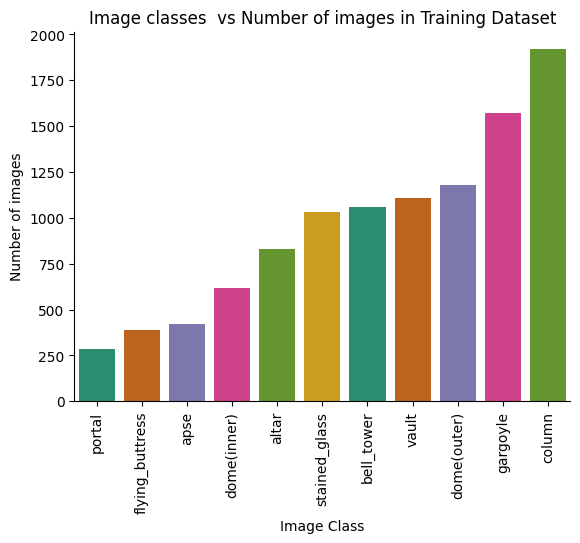

index      Image_Class  Num_Images
0      10           portal         287
1       2  flying_buttress         387
2       0             apse         423
3       8      dome(inner)         616
4       4            altar         829
5       7    stained_glass        1033
6       5       bell_tower        1059
7       6            vault        1110
8       9      dome(outer)        1177
9       3         gargoyle        1571
10      1           column        1919

In [ ]:


data_dir = pathlib.Path(train_data_path)
print(now())
plot_class_numbers(data_dir,"Training Dataset")


2025-04-03:11:23:45


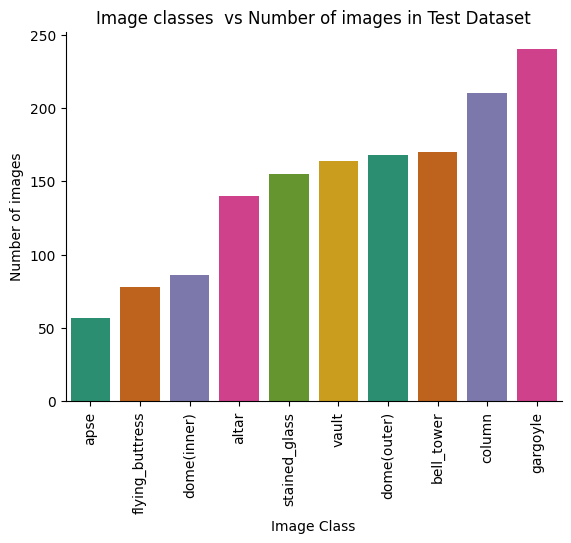

index      Image_Class  Num_Images
0      0             apse          57
1      2  flying_buttress          78
2      8      dome(inner)          86
3      4            altar         140
4      7    stained_glass         155
5      6            vault         164
6      9      dome(outer)         168
7      5       bell_tower         170
8      1           column         210
9      3         gargoyle         240

In [ ]:
data_dir = pathlib.Path(test_data_path)
print(now())
plot_class_numbers(data_dir,"Test Dataset")

## Display sample images

2025-04-03:10:13:05


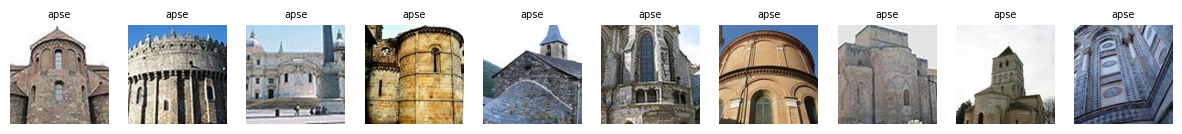

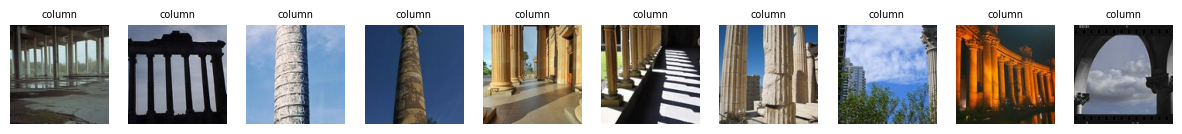

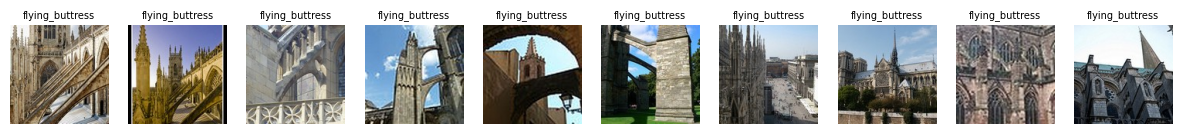

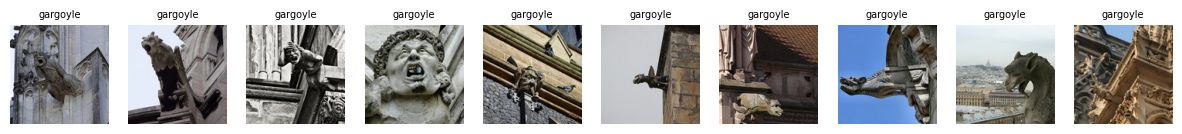

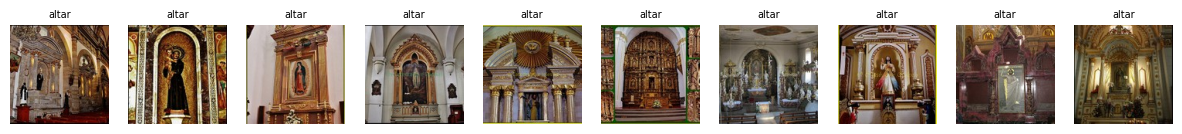

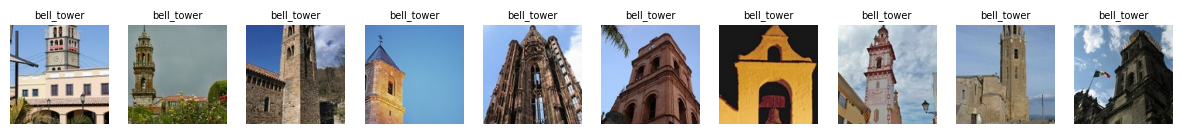

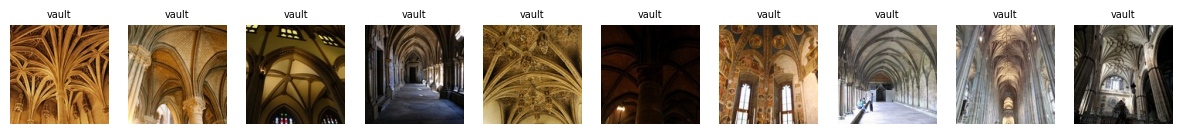

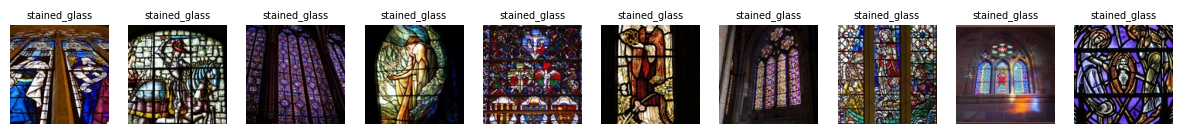

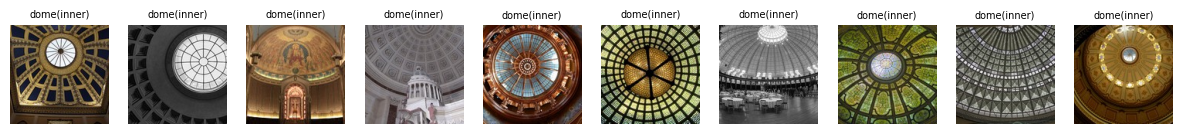

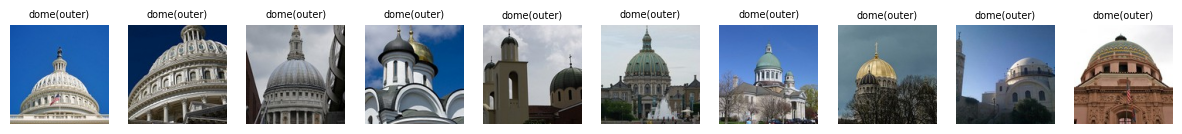

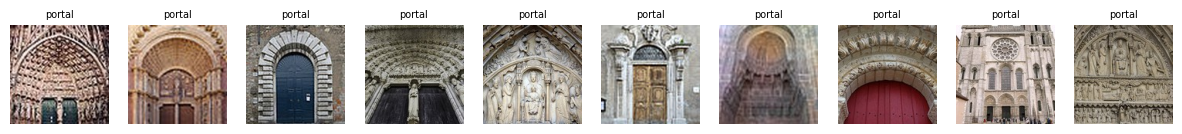

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

display_images_path = {}
print(now())
for sub_dir in os.listdir(train_data_path):
    dir_path = os.path.join(train_data_path, sub_dir)
    is_dir = os.path.isdir(dir_path)
    if is_dir:
      plt.figure(figsize=(15,8))
      for i in range(10):
        file = os.listdir(dir_path)[i]
        file_path = os.path.join(dir_path, file)
        display_images_path[file_path] = sub_dir
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,10,i+1)
        plt.title(sub_dir,fontsize = 7)
        plt.axis('off')
        plt.imshow(img)
      plt.show()

## Create training and validation datasets ##

In [35]:
# create data sets
# using the latest tf.data for efficient input pipelines.
# https://www.tensorflow.org/guide/data

import tensorflow as tf
def get_ds(data_dir,seed = 43,subset='training',validation_split=0.2,image_size=(255,255),batch_size=32) -> tf.data.Dataset:
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=seed,
    validation_split = validation_split,
    subset=subset,
    image_size=image_size,
    batch_size=batch_size)
    train_ds.class_names
    return train_ds

data_dir = pathlib.Path(train_data_path)
train_ds = get_ds(data_dir,image_size=(height,width),batch_size=batch_size)
val_ds = get_ds(data_dir,subset='validation',image_size=(height,width),batch_size=batch_size)
class_names = train_ds.class_names
print(now())
print(class_names)



Found 10411 files belonging to 11 classes.
Using 8329 files for training.
Found 10411 files belonging to 11 classes.
Using 2082 files for validation.
2025-04-04:10:49:06
['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'portal', 'stained_glass', 'vault']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Basic CNN Model

In [ ]:
model_layers = []
model_layers.extend(get_img_augmentation_layers(height,width))
model_layers.extend(get_conv_layers())
model_layers.extend(get_fcn())
model_layers.append(tf.keras.layers.Dense(len(class_names),activation='softmax'))
model_c = Sequential(model_layers)
model_c.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 11)                  │           1,4

 Total params: 734,731 (2.80 MB)

 Trainable params: 733,963 (2.80 MB)

 Non-trainable params: 768 (3.00 KB)

## Compile Model ###

In [ ]:
model_c.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
model_c.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 11)                  │           1,4

 Total params: 734,731 (2.80 MB)

 Trainable params: 733,963 (2.80 MB)

 Non-trainable params: 768 (3.00 KB)

## Train CNN Model with Early Stopping and Checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


early_stop=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=patience,min_delta=delta)
checkpoint=ModelCheckpoint('best_model_c.keras',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

epochs=100
history_c = model_c.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2702 - loss: 2.1669
Epoch 1: val_accuracy improved from -inf to 0.16234, saving model to best_model_c.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.2706 - loss: 2.1653 - val_accuracy: 0.1623 - val_loss: 2.2379
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3912 - loss: 1.7111
Epoch 2: val_accuracy improved from 0.16234 to 0.24688, saving model to best_model_c.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.3914 - loss: 1.7105 - val_accuracy: 0.2469 - val_loss: 2.0033
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4968 - loss: 1.4282
Epoch 3: val_accuracy improved from 0.24688 to 0.43132, saving model to best_model_c.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 0.4969 - loss: 1.4280 - val_accuracy: 0.4313 - val_loss: 1.5387
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5481 - loss: 1.2896
Epoch 4: val_a

## Check Accuracy and loss values

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model_c.keras')
print_scores(model,val_ds,train_ds,cnn)
history_map[cnn] = history_c
model_map[cnn] = model

Displaying accuracy and loss for CNN
2025-04-03:10:21:07
val accuracy 0.6095, val_loss 1.2556
train_accuarcy 0.6283, train_loss 1.1832


# MobileNetV2 with fine tuning

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

import tensorflow as tf



model_m = MobileNetV2(
    input_shape=(height,width,3),
    include_top=False,
    weights="imagenet",
    input_tensor=(None),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name='MobileNet',
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Create Model

In [ ]:

model_t = create_transfer_model(model_m,len(class_names),
                                data_augmentation=get_img_augmentation_layers(height,width),

                                fcn = get_fcn())

update_model_map(mobilenet,model_t)

added layer <RandomFlip name=random_flip_2, built=True>
added layer <RandomRotation name=random_rotation_2, built=True>
added layer <RandomZoom name=random_zoom_2, built=True>
added layer <Rescaling name=rescaling_2, built=True>
added layer <Flatten name=flatten_2, built=True>
added layer <Dense name=dense_6, built=True>
added layer <BatchNormalization name=batch_normalization_4, built=True>
added layer <Dropout name=dropout_4, built=True>
added layer <Dense name=dense_7, built=True>
added layer <BatchNormalization name=batch_normalization_5, built=True>
added layer <Dropout name=dropout_5, built=True>


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNet (Functional)               │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,350,411 (70.00 MB)

 Trainable params: 16,091,659 (61.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

## Compile Model

In [ ]:
model_t.compile(optimizer='adam' ,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy']
                )


## Train Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


early_stop=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=patience,min_delta=delta)
checkpoint=ModelCheckpoint('best_model.keras',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

epochs=100
history = model_t.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8161 - loss: 0.5990
Epoch 1: val_accuracy improved from -inf to 0.91691, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.8166 - loss: 0.5976 - val_accuracy: 0.9169 - val_loss: 0.2674
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9264 - loss: 0.2244
Epoch 2: val_accuracy improved from 0.91691 to 0.93516, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9265 - loss: 0.2244 - val_accuracy: 0.9352 - val_loss: 0.1868
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9504 - loss: 0.1565
Epoch 3: val_accuracy improved from 0.93516 to 0.94044, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9503 - loss: 0.1565 - val_accuracy: 0.9404 - val_loss: 0.1904
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9656 - loss: 0.1138
Epoch 4: val_accurac

## Plot accuracy and loss

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')
print_scores(model,val_ds,train_ds,mobilenet)
history_map[mobilenet] = history
model_map[mobilenet] = model

Displaying accuracy and loss for MobileNetV2
2025-04-03:10:25:24
val accuracy 0.9419, val_loss 0.1804
train_accuarcy 0.9724, train_loss 0.0840


In [ ]:
# image_label_map,image_map,image_list = get_predicted_labels(model,class_names,test_data_path)
# print(len(image_map))
# display_test_images(image_label_map,image_map,image_list,'Transfer Mddel. Title is the predicted label')

## Display Confusion Matrix and classification report

Total images in validation set = 2082
Num_Images : 2082,Num_batches : 32, Num_Residuals: 34
true_labels 2018, predicted_labels 2018
Confusion Matrix
[[152   0   0   0   0   0   0   1   0   1   4]
 [  1  70   6   0   0   1   2   0   0   0   0]
 [  1   9 203   1   0   1   0   1   1   0   0]
 [  2   2   4 365   0   0   2   0   1   0   4]
 [  1   0   0   0 128   0   0   0   0   0   1]
 [  0   2   3   0   0 211   0   0   1   0   0]
 [  1  12  10   1   0   0  54   1   2   0   0]
 [  2   1   3   1   0   0   4 282   0   0   0]
 [  3   6   0   1   0   0   0   0  46   0   2]
 [  0   0   0   0   1   0   0   0   0 203   1]
 [  4   0   0   6   0   0   0   0   0   1 188]]

Confusion Matrix Displayed



<Figure size 1000x1000 with 0 Axes>

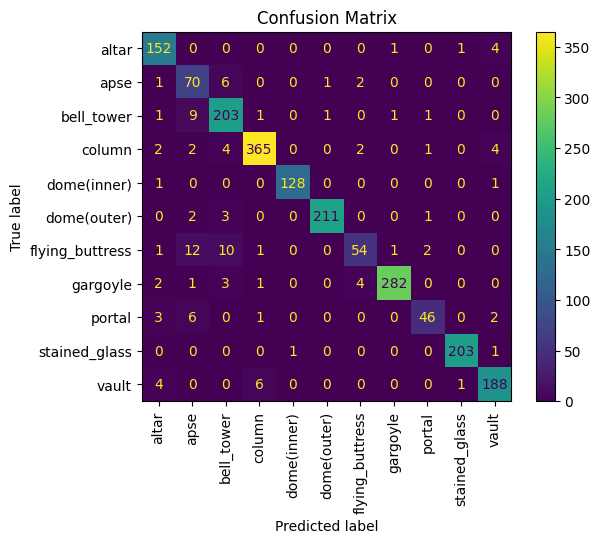

2025-04-03:10:27:38
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       158
           1       0.69      0.88      0.77        80
           2       0.89      0.94      0.91       217
           3       0.97      0.96      0.97       380
           4       0.99      0.98      0.99       130
           5       0.99      0.97      0.98       217
           6       0.87      0.67      0.76        81
           7       0.99      0.96      0.98       293
           8       0.90      0.79      0.84        58
           9       0.99      0.99      0.99       205
          10       0.94      0.94      0.94       199

    accuracy                           0.94      2018
   macro avg       0.92      0.91      0.91      2018
weighted avg       0.95      0.94      0.94      2018



In [ ]:
true_labels,predicted_labels = get_metrics(model, validation_ds=val_ds, val_split=0.2,batch_size=64)
display_cm(true_labels, predicted_labels)
print(now())

print(f'{classification_report(true_labels,predicted_labels)}')

## Print Classification Report

# Vgg16 With fine tuning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model_v = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="vgg16",
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_t = create_transfer_model(model_v,len(class_names),
                                data_augmentation=get_img_augmentation_layers(height,width),
                                fcn = get_fcn())
update_model_map(vgg16,model_t)

added layer <RandomFlip name=random_flip_3, built=True>
added layer <RandomRotation name=random_rotation_3, built=True>
added layer <RandomZoom name=random_zoom_3, built=True>
added layer <Rescaling name=rescaling_3, built=True>
added layer <Flatten name=flatten_3, built=True>
added layer <Dense name=dense_9, built=True>
added layer <BatchNormalization name=batch_normalization_6, built=True>
added layer <Dropout name=dropout_6, built=True>
added layer <Dense name=dense_10, built=True>
added layer <BatchNormalization name=batch_normalization_7, built=True>
added layer <Dropout name=dropout_7, built=True>


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,173,323 (80.77 MB)

 Trainable params: 6,457,867 (24.63 MB)

 Non-trainable params: 14,715,456 (56.14 MB)

## Compile the model

In [ ]:
model_t.compile(optimizer='adam' ,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy']
                )

## Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


early_stop=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=patience,min_delta=delta)
checkpoint=ModelCheckpoint('best_model.keras',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

epochs=100
history = model_t.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7421 - loss: 0.8465
Epoch 1: val_accuracy improved from -inf to 0.78722, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 501ms/step - accuracy: 0.7426 - loss: 0.8446 - val_accuracy: 0.7872 - val_loss: 0.7026
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8966 - loss: 0.3323
Epoch 2: val_accuracy improved from 0.78722 to 0.91643, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 458ms/step - accuracy: 0.8966 - loss: 0.3323 - val_accuracy: 0.9164 - val_loss: 0.2586
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9119 - loss: 0.2650
Epoch 3: val_accuracy did not improve from 0.91643
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - accuracy: 0.9119 - loss: 0.2650 - val_accuracy: 0.8924 - val_loss: 0.3461
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9326 - loss: 0.2091
Epoch 4: val_accuracy improved from 0.91643 to 0.91787, sa

## Plot accuracy and loss graphs

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')
print_scores(model,val_ds,train_ds,vgg16)
history_map[vgg16] = history
model_map[vgg16] = model

Displaying accuracy and loss for VGG16
2025-04-03:10:37:30
val accuracy 0.9313, val_loss 0.2265
train_accuarcy 0.9713, train_loss 0.0879


## Display Confusion matrix and classifictaion report

Total images in validation set = 2082
Num_Images : 2082,Num_batches : 32, Num_Residuals: 34
true_labels 2018, predicted_labels 2018
Confusion Matrix
[[148   2   2   3   0   0   0   0   2   1   2]
 [  0  71   6   0   0   0   1   0   0   0   0]
 [  0   5 196   2   1   3   0   5   2   0   0]
 [  1   0   4 365   0   0   0   5   1   0   3]
 [  1   0   0   0 130   0   0   0   0   0   1]
 [  0   2   4   1   1 210   1   1   0   0   0]
 [  0   6   8   5   0   1  47  13   2   0   0]
 [  0   1   3   3   0   0   1 283   0   0   0]
 [  1   3   2   2   0   0   0   1  49   0   2]
 [  0   0   0   1   1   0   0   0   0 200   3]
 [  2   1   0   5   1   0   0   3   0   2 183]]

Confusion Matrix Displayed



<Figure size 1000x1000 with 0 Axes>

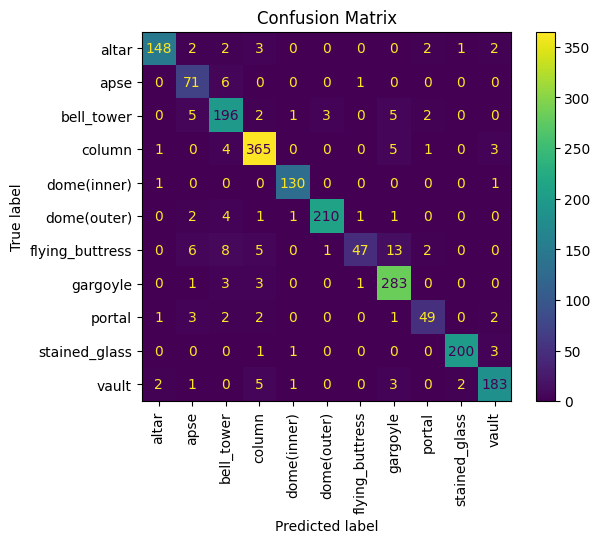

2025-04-03:10:39:55
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       160
           1       0.78      0.91      0.84        78
           2       0.87      0.92      0.89       214
           3       0.94      0.96      0.95       379
           4       0.97      0.98      0.98       132
           5       0.98      0.95      0.97       220
           6       0.94      0.57      0.71        82
           7       0.91      0.97      0.94       291
           8       0.88      0.82      0.84        60
           9       0.99      0.98      0.98       205
          10       0.94      0.93      0.94       197

    accuracy                           0.93      2018
   macro avg       0.92      0.90      0.91      2018
weighted avg       0.93      0.93      0.93      2018



In [ ]:
true_labels,predicted_labels = get_metrics(model, validation_ds=val_ds, val_split=0.2,batch_size=64)
display_cm(true_labels, predicted_labels)
print(now())
print(classification_report(true_labels,predicted_labels))

# EfficientNetV2B0 model

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

model_e = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(height,width,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=False
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_t = model_t = create_transfer_model(model_e,len(class_names),
                                data_augmentation=get_img_augmentation_layers(height,width),
                                fcn = get_fcn())


added layer <RandomFlip name=random_flip, built=True>
added layer <RandomRotation name=random_rotation, built=True>
added layer <RandomZoom name=random_zoom, built=True>
added layer <Rescaling name=rescaling, built=True>
added layer <Flatten name=flatten, built=True>
added layer <Dense name=dense, built=True>
added layer <BatchNormalization name=batch_normalization, built=True>
added layer <Dropout name=dropout, built=True>
added layer <Dense name=dense_1, built=True>
added layer <BatchNormalization name=batch_normalization_1, built=True>
added layer <Dropout name=dropout_1, built=True>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,011,739 (83.97 MB)

 Trainable params: 16,091,659 (61.38 MB)

 Non-trainable params: 5,920,080 (22.58 MB)

## Compile the model

In [ ]:
model_t.compile(optimizer='adam' ,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy']
                )

## Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


early_stop=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=patience,min_delta=delta)
checkpoint=ModelCheckpoint('best_model.keras',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

epochs=100
history = model_t.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7850 - loss: 0.7175
Epoch 1: val_accuracy improved from -inf to 0.94765, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.7855 - loss: 0.7155 - val_accuracy: 0.9476 - val_loss: 0.1733
Epoch 2/100
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9270 - loss: 0.2372
Epoch 2: val_accuracy improved from 0.94765 to 0.95005, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9270 - loss: 0.2371 - val_accuracy: 0.9500 - val_loss: 0.1525
Epoch 3/100
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9361 - loss: 0.1928
Epoch 3: val_accuracy improved from 0.95005 to 0.95437, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.9361 - loss: 0.1929 - val_accuracy: 0.9544 - val_loss: 0.1462
Epoch 4/100
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9522 - loss: 0.1514
Epoch 4: val_accurac

## Plot accuracy and loss

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')
print_scores(model,val_ds,train_ds,efficientnet)
history_map[efficientnet] = history
model_map[efficientnet] = model

Displaying accuracy and loss for EfficientNetV2B0
2025-04-03:11:28:12
val accuracy 0.9606, val_loss 0.1266
train_accuarcy 0.9849, train_loss 0.0507


## Display Confusion matrix and classification report

Total images in validation set = 2082
Num_Images : 2082,Num_batches : 32, Num_Residuals: 34
true_labels 2018, predicted_labels 2018
Confusion Matrix
[[153   0   0   0   2   0   0   0   0   0   3]
 [  0  71   5   0   0   0   2   0   0   0   1]
 [  1   2 211   0   0   4   0   0   0   0   0]
 [  0   0   3 370   0   0   0   3   0   0   3]
 [  1   0   0   0 128   0   0   0   0   0   2]
 [  0   0   1   1   0 214   0   1   1   0   0]
 [  1   1   7   2   0   1  62   8   1   0   1]
 [  0   0   0   1   0   0   5 287   0   0   0]
 [  2   0   0   1   0   0   0   1  51   2   2]
 [  1   0   0   1   1   0   0   0   0 199   1]
 [  2   0   0   3   0   0   0   0   0   0 191]]

Confusion Matrix Displayed



<Figure size 1000x1000 with 0 Axes>

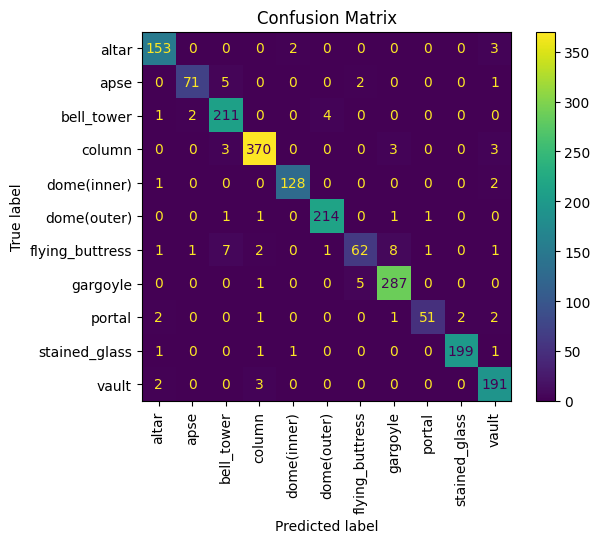

2025-04-03:10:46:19
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       158
           1       0.96      0.90      0.93        79
           2       0.93      0.97      0.95       218
           3       0.98      0.98      0.98       379
           4       0.98      0.98      0.98       131
           5       0.98      0.98      0.98       218
           6       0.90      0.74      0.81        84
           7       0.96      0.98      0.97       293
           8       0.96      0.86      0.91        59
           9       0.99      0.98      0.99       203
          10       0.94      0.97      0.96       196

    accuracy                           0.96      2018
   macro avg       0.96      0.94      0.95      2018
weighted avg       0.96      0.96      0.96      2018



In [ ]:
true_labels,predicted_labels = get_metrics(model, validation_ds=val_ds, val_split=0.2,batch_size=64)
display_cm(true_labels, predicted_labels)
print(now())
print(classification_report(true_labels,predicted_labels))

## Display Accuracy/Loss graphs for all models

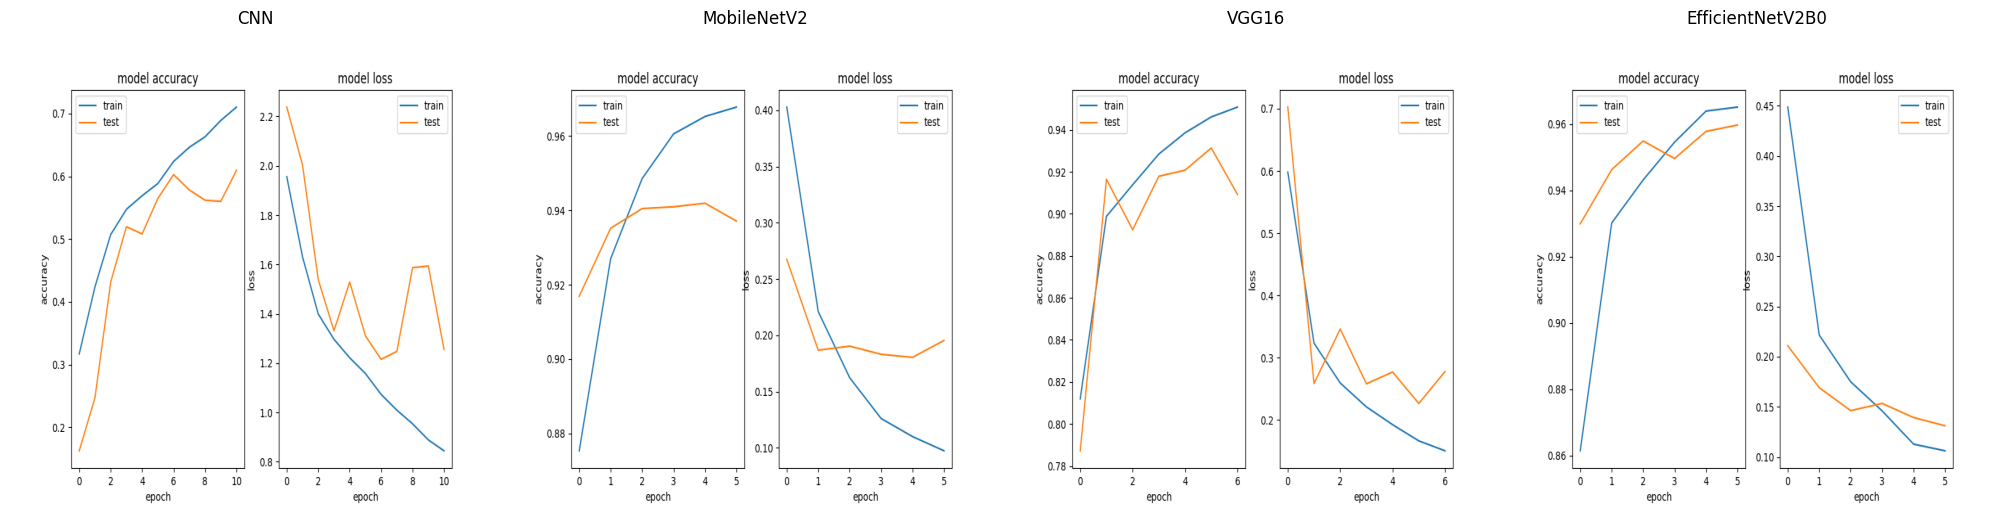

In [ ]:
import matplotlib.image as mpimg

#save the images
for name,history in history_map.items():
    plot_accuracy_loss_graphs(history,name,show=False)

#display the images
# plt.figure(figsize=(16,16))
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(20,20),constrained_layout=True)
for i,(name,_) in enumerate(model_map.items()):
  figure = name+'.png'
  img = mpimg.imread(figure)
  axes[i].set_title(name)
  axes[i].axis('off')
  axes[i].imshow(img, extent=[0, 20, 0, 20])  # This sets the size of the image

plt.show()

# Classify images on the test data with the best model

2025-04-03:11:28:25:Best accuracy for model -> EfficientNetV2B0 , accuracy : 0.9606
Total images = 90
 Sample Predictions for 9 random images per class with EfficientNetV2B0.


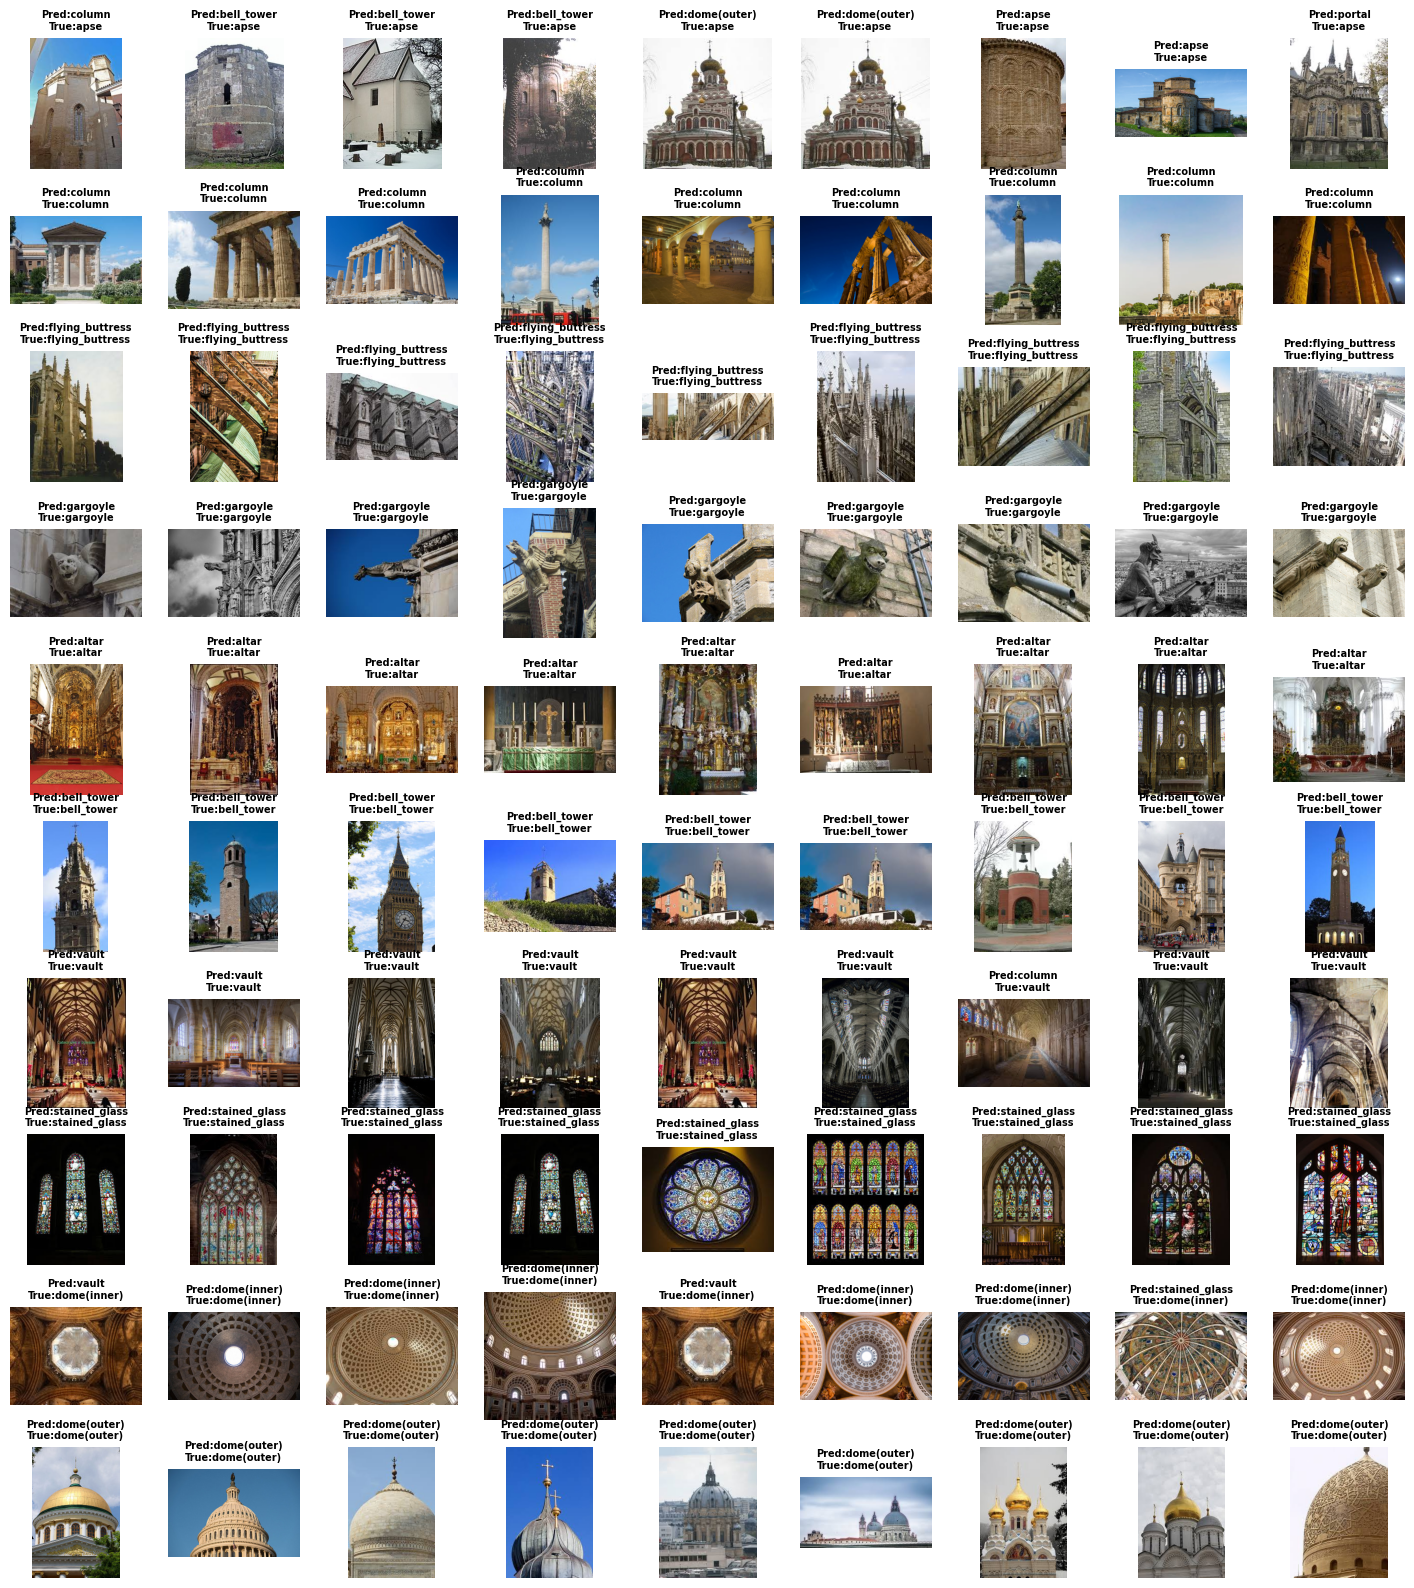

In [ ]:
best_model_name = max(test_accuracy, key=lambda key: test_accuracy[key])
best_model = model_map[best_model_name]
print(f'{now()}:Best accuracy for model -> {best_model_name} , accuracy : {test_accuracy[best_model_name]:.4f}')
image_label_map,image_map,image_list = get_predicted_labels(model,class_names,test_data_path)
display_test_images(image_label_map,image_map,image_list,f'{best_model_name}')

# Part2 - Recommender System

In [26]:
#Formatting unicodes
BOLD_START = '\033[1m'
END = '\033[0m'
CYAN = '\033[96m'
DARKCYAN = '\033[36m'
UNDERLINE = '\033[4m'


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


user_csv_kaggle = '/kaggle/input/user-ratings-historical-structures/Part 2/user.csv'
user_csv_github = 'https://raw.githubusercontent.com/tksundar/historical-structure-identification/refs/heads/master/user.csv'
user_csv = user_csv_kaggle if os.path.exists(user_csv_kaggle) else user_csv_github

user_data = pd.read_csv(user_csv, skip_blank_lines=True,skipinitialspace=True)
user_data.head()

User_Id                   Location  Age
0        1      Semarang, Jawa Tengah   20
1        2         Bekasi, Jawa Barat   21
2        3        Cirebon, Jawa Barat   23
3        4         Bekasi, Jawa Barat   21
4        5  Lampung, Sumatera Selatan   20

## Check for null values

In [2]:
user_data.isnull().sum()

User_Id     0
Location    0
Age         0
dtype: int64

In [3]:
locations = user_data['Location']
cities = []
towns = []
for location in locations:
  towns.append(location.split(',')[0].strip())
  cities.append(location.split(',')[-1].strip())
# create a similarity matrix to group similar users based on the age and location features
user_data['Province'] = cities

user_data['combined_features'] = user_data.apply(lambda row: row['Location']+str(row['Age']),axis=1)
user_data.head()


User_Id                   Location  Age          Province  \
0        1      Semarang, Jawa Tengah   20       Jawa Tengah   
1        2         Bekasi, Jawa Barat   21        Jawa Barat   
2        3        Cirebon, Jawa Barat   23        Jawa Barat   
3        4         Bekasi, Jawa Barat   21        Jawa Barat   
4        5  Lampung, Sumatera Selatan   20  Sumatera Selatan   

             combined_features  
0      Semarang, Jawa Tengah20  
1         Bekasi, Jawa Barat21  
2        Cirebon, Jawa Barat23  
3         Bekasi, Jawa Barat21  
4  Lampung, Sumatera Selatan20

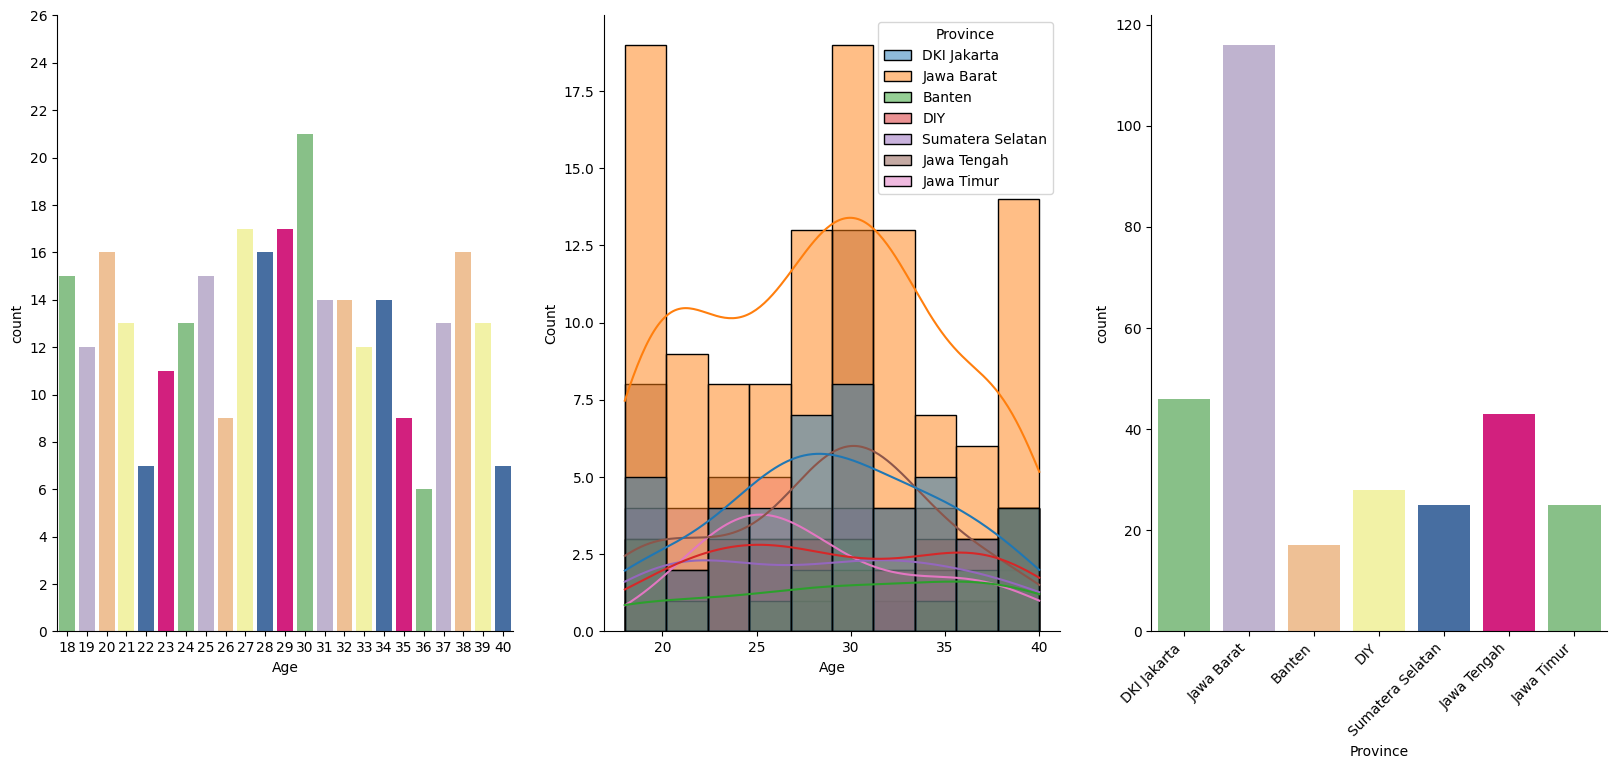

In [4]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

df = user_data.sort_values(by='Age',ascending=True).reset_index(drop=True)
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
_=sns.countplot(data=df,x='Age',palette=sns.mpl_palette('Accent'))
_=plt.yticks(range(0,28,2))
sns.despine(fig=plt.gcf(), ax=plt.gca())

plt.subplot(1,3,2)
_=sns.histplot(data=df,x='Age',hue='Province',kde=True)
sns.despine(fig=plt.gcf(), ax=plt.gca())

plt.subplot(1,3,3)
ax=sns.countplot(data=df,x='Province',palette=sns.mpl_palette('Accent'),)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine(fig=plt.gcf(), ax=plt.gca())


plt.show()


Maximum tourists are in the 30 age group

Maximum tourusts are coming from the Jawa Barat province

## Import tourism places data and check null values

In [6]:
import numpy as np
import pprint
import warnings
warnings.filterwarnings('ignore')
places_csv_kaggle = '/kaggle/input/user-ratings-historical-structures/Part 2/tourism_with_id.xlsx'
places_csv_github = 'https://raw.githubusercontent.com/tksundar/historical-structure-identification/refs/heads/master/tourism_with_id.csv'

places_csv = places_csv_kaggle if os.path.exists(places_csv_kaggle) else places_csv_github

places_data_raw = pd.read_csv(places_csv)
places_data_raw.drop(['Unnamed: 11','Unnamed: 12'], axis=1, inplace=True)
print(places_data_raw.isnull().sum())



# handle null values

grp_by_city = pd.DataFrame(places_data_raw.groupby('City').Time_Minutes.mean())
grp_by_city =grp_by_city.assign(Time_Minutes=grp_by_city['Time_Minutes'].round(2))
city_time_dict = grp_by_city.to_dict().get('Time_Minutes')


places_data = places_data_raw.copy(deep = True)
places_data.loc[:,'Time_Minutes'] = places_data.apply(lambda row: city_time_dict.get(row['City']) if np.isnan(row['Time_Minutes']) else row['Time_Minutes'],axis=1 )
places_data = places_data.assign(Time_Minutes=places_data['Time_Minutes'].round(2))
print('\nAfter fixing null values with appropriate average values')
print(places_data.isnull().sum().any())

# fix zero price
grp_by_category = pd.DataFrame(places_data.groupby('Category').Price.mean())
category_price_dict = grp_by_category.to_dict().get('Price')
places_data.loc[:,'Price'] = places_data.apply(lambda row: category_price_dict.get(row['Category']) if row['Price'] == 0 else row['Price'],axis=1 )
places_data = places_data.assign(Price=places_data['Price'].round(2))


Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64

After fixing null values with appropriate average values
False


## Categories of Tourist spots

In [68]:
def get_english_category(category):
  return category_english.get(category)

category_english = {
    'Budaya' : 'Budaya(Culture)',
    'Taman Hiburan' : 'Taman Hiburan(Amusement Park)',
    'Cagar Alam' : 'Cagar Alam(Game Reserve)',
    'Bahari' : 'Bahari(Marine)',
    'Pusat Perbelanjaan' : '(Shopping Mall)',
    'Tempat Ibadah' : 'Tempat Ibadah(Place of Worhsip)'
}

places_data['Category_English'] = places_data['Category'].apply(lambda x: get_english_category(x))
places_data.head(10)

Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   
5         6            Taman Impian Jaya Ancol   
6         7             Kebun Binatang Ragunan   
7         8                      Ocean Ecopark   
8         9                   Pelabuhan Marina   
9        10                       Pulau Tidung   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   
5  Taman Impian Jaya Ancol merupakan sebuah objek...  Taman Hiburan  Jakarta   
6  Kebun Binatang Ragunan adalah sebuah kebun bin...     Cagar Alam  Jakarta   
7  Ocean Ecopark Salah satu zona rekreasi Ancol y...  Taman Hiburan  Jakarta   
8  Pelabuhan Marina Ancol berada di kawasan Taman...         Bahari  Jakarta   
9  Pulau Tidung adalah salah satu kelurahan di ke...         Bahari  Jakarta   

       Price  Rating  Time_Minutes  \
0   20000.00     4.6         15.00   
1   15888.89     4.6         90.00   
2  270000.00     4.6        360.00   
3   10000.00     4.5         98.51   
4   94000.00     4.5         60.00   
5   25000.00     4.5         10.00   
6    4000.00     4.5         98.51   
7  180000.00     4.0         98.51   
8  175000.00     4.4         98.51   
9  150000.00     4.5         98.51   

                                        Coordinate       Lat        Long  \
0          {'lat': -6.1753924, 'lng': 106.8271528} -6.175392  106.827153   
1  {'lat': -6.137644799999999, 'lng': 106.8171245} -6.137645  106.817125   
2  {'lat': -6.125312399999999, 'lng': 106.8335377} -6.125312  106.833538   
3  {'lat': -6.302445899999999, 'lng': 106.8951559} -6.302446  106.895156   
4             {'lat': -6.12419, 'lng': 106.839134} -6.124190  106.839134   
5  {'lat': -6.117333200000001, 'lng': 106.8579951} -6.117333  106.857995   
6          {'lat': -6.3124593, 'lng': 106.8201865} -6.312459  106.820187   
7  {'lat': -6.125801699999999, 'lng': 106.8363249} -6.125802  106.836325   
8              {'lat': 1.07888, 'lng': 103.931398}  1.078880  103.931398   
9  {'lat': -5.803205300000001, 'lng': 106.5237907} -5.803205  106.523791   

                Category_English  
0                Budaya(Culture)  
1                Budaya(Culture)  
2  Taman Hiburan(Amusement Park)  
3  Taman Hiburan(Amusement Park)  
4  Taman Hiburan(Amusement Park)  
5  Taman Hiburan(Amusement Park)  
6       Cagar Alam(Game Reserve)  
7  Taman Hiburan(Amusement Park)  
8                 Bahari(Marine)  
9                 Bahari(Marine)

## Plot places by city

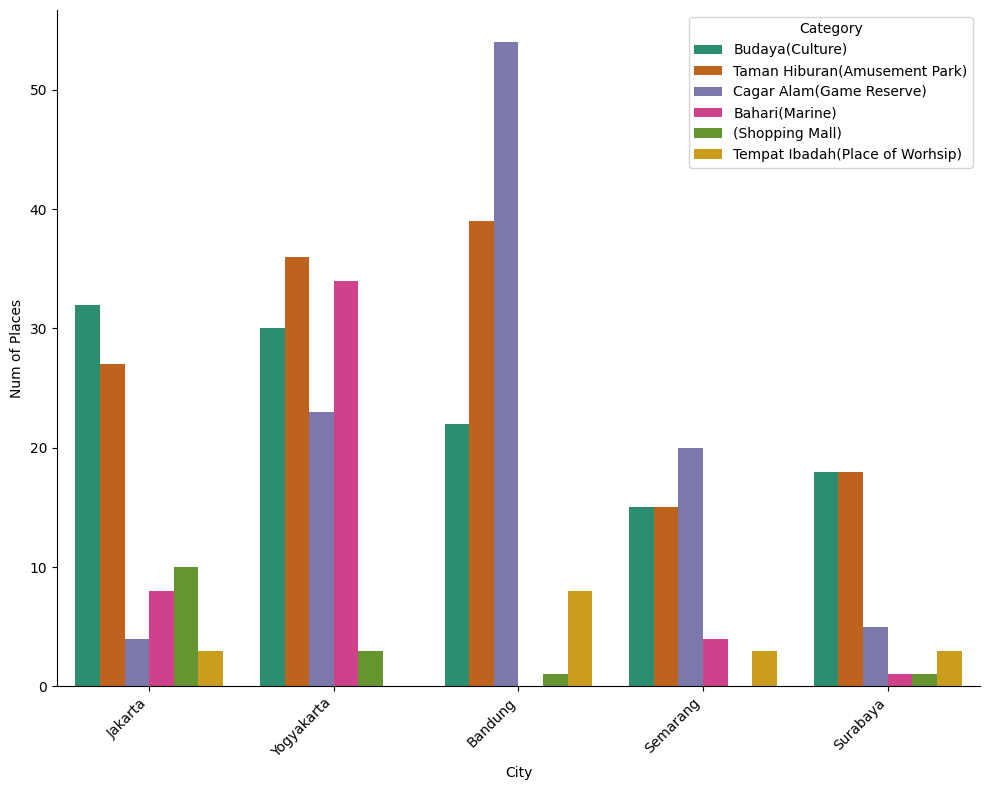

In [ ]:

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,8))

ax=sns.countplot(data=places_data,x='City' ,hue='Category_English', palette=sns.mpl_palette('Dark2'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(title="Category", loc='best')
_=ax.set_ylabel('Num of Places')
sns.despine(fig=plt.gcf(), ax=plt.gca())

plt.tight_layout()
plt.show()

Categories Of tourist spots:

1.   	Budaya	Budaya(Culture)
2.  Cagar Alam	Cagar Alam(Game Reserve)
3.  Taman Hiburan	Taman Hiburan(Amusement Park)
4.  	Bahari	Bahari(Marine)
5.  	Pusat Perbelanjaan	(Shopping Mall)
6.  Tempat Ibadah	Tempat Ibadah(Place of Worhsip)

A nature enthusiast shold like Game Reserves. So he is most likely to visit Bandung which has the highest number of game reserves


## Import ratings data

In [60]:
tourism_rating_csv_kaggle = '/kaggle/input/user-ratings-historical-structures/Part 2/tourism_rating.csv'
tourism_rating_csv_github = 'https://raw.githubusercontent.com/tksundar/historical-structure-identification/refs/heads/master/tourism_rating.csv'
tourism_rating_csv = tourism_rating_csv_kaggle if os.path.exists(tourism_rating_csv_kaggle) else tourism_rating_csv_github
tourism_rating = pd.read_csv(tourism_rating_csv).reset_index()
print(tourism_rating.isnull().sum())
print(tourism_rating.shape)
tourism_rating.drop_duplicates(inplace=True)
print(tourism_rating.shape)


index            0
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64
(10000, 4)
(10000, 4)


## Check if all places have been rated by users

In [70]:
# Places not rated by any user
excluded = places_data[~places_data['Place_Id'].isin(tourism_rating['Place_Id'])]
excluded.shape

(0, 12)

## Combine the places and ratings data

In [61]:
print(tourism_rating.columns)
features = ['Place_Name','City','Category','Price','Time_Minutes']
for feature in features:
  feature_map = places_data[['Place_Id',feature]].set_index('Place_Id').to_dict()[feature]
  tourism_rating[feature] = tourism_rating['Place_Id'].apply(lambda x: feature_map.get(x))
tourism_rating.head()


Index(['index', 'User_Id', 'Place_Id', 'Place_Ratings'], dtype='object')


index  User_Id  Place_Id  Place_Ratings                     Place_Name  \
0      0        1       179              3                Candi Ratu Boko   
1      1        1       344              2                  Pantai Marina   
2      2        1         5              5       Atlantis Water Adventure   
3      3        1       373              3         Museum Kereta Ambarawa   
4      4        1       101              4  Kampung Wisata Sosro Menduran   

         City       Category     Price  Time_Minutes  
0  Yogyakarta         Budaya  75000.00         90.00  
1    Semarang         Bahari   3000.00         70.36  
2     Jakarta  Taman Hiburan  94000.00         60.00  
3    Semarang         Budaya  10000.00         60.00  
4  Yogyakarta         Budaya  15888.89         78.42

In [62]:
tourism_rating['combined_features'] = tourism_rating.apply(lambda row: str(row['Place_Ratings'])+row['Category']+str(row['Price'])+str(row['Time_Minutes']),axis=1)

tourism_rating.head(10)

index  User_Id  Place_Id  Place_Ratings                      Place_Name  \
0      0        1       179              3                 Candi Ratu Boko   
1      1        1       344              2                   Pantai Marina   
2      2        1         5              5        Atlantis Water Adventure   
3      3        1       373              3          Museum Kereta Ambarawa   
4      4        1       101              4   Kampung Wisata Sosro Menduran   
5      5        1       312              2  Taman Hutan Raya Ir. H. Juanda   
6      6        1       258              5              Museum Gedung Sate   
7      7        1        20              4           Museum Taman Prasasti   
8      8        1       154              2           Pantai Ngrawe (Mesra)   
9      9        1       393              5           Taman Harmoni Keputih   

         City       Category     Price  Time_Minutes  \
0  Yogyakarta         Budaya  75000.00         90.00   
1    Semarang         Bahari   3000.00         70.36   
2     Jakarta  Taman Hiburan  94000.00         60.00   
3    Semarang         Budaya  10000.00         60.00   
4  Yogyakarta         Budaya  15888.89         78.42   
5     Bandung     Cagar Alam  11000.00         90.00   
6     Bandung         Budaya   5000.00        101.40   
7     Jakarta         Budaya   2000.00         90.00   
8  Yogyakarta         Bahari  10000.00         78.42   
9    Surabaya     Cagar Alam  22533.02         60.00   

           combined_features  
0         3Budaya75000.090.0  
1         2Bahari3000.070.36  
2  5Taman Hiburan94000.060.0  
3         3Budaya10000.060.0  
4       4Budaya15888.8978.42  
5     2Cagar Alam11000.090.0  
6         5Budaya5000.0101.4  
7          4Budaya2000.090.0  
8        2Bahari10000.078.42  
9    5Cagar Alam22533.0260.0

## Obtain Cosine Similarity matrix

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


cv = CountVectorizer()
count_matrix = cv.fit_transform(tourism_rating['combined_features'])
cosine_sim = cosine_similarity(count_matrix)



In [75]:
def find_place_name_from_index(index):
    return tourism_rating[tourism_rating.index == index].loc[:,['Place_Id','Place_Name','City','Category','Price','Time_Minutes']]#.values[0]

def find_index_from_place_name(place_name):
    return tourism_rating[tourism_rating.Place_Name == place_name]["index"].values[0]

def recommend_top_places(number_of_places=5):

    print('%s%s%sWelcome to Places Recommender System%s\n'%(BOLD_START,CYAN,UNDERLINE,END))
    name = input("Enter the current tourist spot: ")
    place_index = find_index_from_place_name(name)
    place_id = find_place_name_from_index(place_index)['Place_Id'].values[0]


    similar_places = list(enumerate(cosine_sim[place_index]))
    sorted_similar_places = sorted(similar_places,key=lambda x:x[1],reverse=True)[1:]



    print('\n%s%sTop 5 recomendations of places similar to %s(Place_Id:%d)%s'%(BOLD_START,DARKCYAN,name,place_id,END))
    place_ids = set()
    place_ids.add(place_id)

    reco_df = pd.DataFrame()
    cosines = []
    for element in sorted_similar_places:
        df  = find_place_name_from_index(element[0])
        id = df['Place_Id'].values[0]
        cosine = element[1]
        if not id in place_ids:
          place_ids.add(id)
          reco_df = pd.concat([reco_df,df] )
          cosines.append(cosine)
        if len(place_ids) > number_of_places:
          break

    reco_df['cosine_similarity'] = cosines
    return reco_df

reco_df = recommend_top_places()
reco_df


Welcome to Places Recommender System

Enter the current tourist spot: Kebun Binatang Ragunan

Top 5 recomendations of places similar to Kebun Binatang Ragunan(Place_Id:7)


Place_Id                       Place_Name     City    Category    Price  \
528         71  Cibubur Garden Diary (Cibugary)  Jakarta  Cagar Alam  50000.0   
3621        31       Wisata Alam Mangrove Angke  Jakarta  Cagar Alam  25000.0   
28          48             Taman Ismail Marzuki  Jakarta      Budaya   5000.0   
56          18            Museum Bank Indonesia  Jakarta      Budaya   2000.0   
60          17                Museum Fatahillah  Jakarta      Budaya   5000.0   

      Time_Minutes  cosine_similarity  
528          98.51            0.75000  
3621         98.51            0.75000  
28           98.51            0.57735  
56           98.51            0.57735  
60           98.51            0.57735

In [76]:
recommend_top_places()


Welcome to Places Recommender System

Enter the current tourist spot: Taman Harmoni Keputih

Top 5 recomendations of places similar to Taman Harmoni Keputih(Place_Id:393)


Place_Id                     Place_Name        City    Category  \
789        167  Geoforest Watu Payung Turunan  Yogyakarta  Cagar Alam   
3562       392    Ekowisata Mangrove Wonorejo    Surabaya  Cagar Alam   
206        322                    Bukit Jamur     Bandung  Cagar Alam   
377        142                    Ledok Sambi  Yogyakarta  Cagar Alam   
479        406           Kebun Bibit Wonorejo    Surabaya  Cagar Alam   

         Price  Time_Minutes  cosine_similarity  
789   22533.02          60.0           1.000000  
3562  22533.02          60.0           1.000000  
206   22533.02         101.4           0.666667  
377   22533.02         150.0           0.666667  
479   22533.02          30.0           0.666667

In [77]:
recommend_top_places()

Welcome to Places Recommender System

Enter the current tourist spot: Dunia Fantasi

Top 5 recomendations of places similar to Dunia Fantasi(Place_Id:3)


Place_Id                           Place_Name      City       Category  \
49        281                    Tektona Waterpark   Bandung  Taman Hiburan   
68        250  Pesona Nirwana Waterpark & Cottages   Bandung  Taman Hiburan   
73        227               Alun-Alun Kota Bandung   Bandung  Taman Hiburan   
78        382                Kampoeng Kopi Banaran  Semarang  Taman Hiburan   
107       383                        Taman Tabanas  Semarang  Taman Hiburan   

         Price  Time_Minutes  cosine_similarity  
49    60000.00         101.4           0.333333  
68    50000.00         101.4           0.333333  
73    35411.11          60.0           0.333333  
78   200000.00          90.0           0.333333  
107   35411.11          60.0           0.333333

# Conclusions

## Part 1

### Historical places identification

The historical places identification with only a CNN gives decent accuracy as there are a good number of images. However transfer learning with a pretrained model increases accuracy much more. In the three pretrained models that was tried , viz., MobileNetV2, VGG16 and EfficientNetV1B0, the last model gave the best accuracy and predictions.

## Part 2

### Recommender System.

A simple recommender system using **collaborative filtering** was built using cosine similarity. The recommender gives top 5 places based on the cosine similarity with the current place. The current place must be one for which a user rating exists.